In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), "..")))
#import example_package
from example_package.model import BoltzmannMachine

%load_ext autoreload
%autoreload 

In [75]:
def PlotWeights_simple(weights, epoch):
    plt.figure(figsize=(8, 6))
    plt.imshow(weights, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f'Weight Matrix at Epoch {epoch}')
    plt.xlabel('Units')
    plt.ylabel('Units')
    plt.show()

def PlotWeights(model, epoch):
    # Get the weight matrix
    weight_matrix = model.w.detach().cpu().numpy()
    
    # Define the structure of the network
    nv1 = model.nv // 2  # Number of visible units
    nv2 = model.nv // 2  # Number of visible units
    nh = model.nh        # Number of hidden units
    
    # Create a figure for the entire network
    fig, axes = plt.subplots(nv1 + nh + nv2, 1, figsize=(10, 2 * (nv1 + nh + nv2)))
    
    # Define labels for the units
    unit_labels = [f'V1_{i+1}' for i in range(nv1)] + \
                    [f'H_{i+1}' for i in range(nh)] + \
                    [f'V2_{i+1}' for i in range(nv2)]
    
    # Iterate over each unit and plot its connections
    for i in range(model.n):
        ax = axes[i]
        unit_weights = weight_matrix[i, :]
        unit_weights_grid = unit_weights.reshape(1, -1)  # Reshape to (1, 10)
        im = ax.imshow(unit_weights_grid, cmap='viridis', vmin=-1, vmax=1, aspect='auto')
        ax.set_xticks(range(model.n))
        ax.set_xticklabels(unit_labels, rotation=90)
        ax.set_title(f'Unit {i+1} ({unit_labels[i]}) Connections')
        ax.set_yticks([])
        plt.colorbar(im, ax=ax)
        
        for j in range(model.n):
            if j < nv1:
                ax.axvspan(j - 0.5, j + 0.5, color='lightblue', alpha=0.3)  # V1 units
            elif j < nv1 + nh:
                ax.axvspan(j - 0.5, j + 0.5, color='lightgreen', alpha=0.3)  # Hidden units
            else:
                ax.axvspan(j - 0.5, j + 0.5, color='lightcoral', alpha=0.3)  # V2 units
    
    plt.tight_layout()
    plt.suptitle(f'Weight Visualization at Epoch {epoch}', y=1.02)
    plt.show()

In [100]:
def compute_symmetry(matrix_1, matrix_2):
    norm_factor = np.linalg.norm(matrix_1, 'fro') * np.linalg.norm(matrix_2, 'fro')
    if norm_factor == 0:
        return 0
    return np.trace(np.matmul(matrix_1.T, matrix_2)) / norm_factor

def plot_matrices_and_difference(ax_row, matrix_1, matrix_2, title_1, title_2):
    # Plot the first matrix
    im1 = ax_row[0].imshow(matrix_1, cmap='viridis', vmin=-1, vmax=1)
    ax_row[0].set_title(title_1)
    ax_row[0].set_xlabel('Units')
    ax_row[0].set_ylabel('Units')
    plt.colorbar(im1, ax=ax_row[0])
    
    # Plot the second matrix
    im2 = ax_row[1].imshow(matrix_2, cmap='viridis', vmin=-1, vmax=1)
    ax_row[1].set_title(title_2)
    ax_row[1].set_xlabel('Units')
    ax_row[1].set_ylabel('Units')
    plt.colorbar(im2, ax=ax_row[1])
    
    # Plot the difference between the two matrices
    diff = matrix_1 - matrix_2
    im3 = ax_row[2].imshow(diff, cmap='coolwarm', vmin=-1, vmax=1)
    ax_row[2].set_title(f'{title_1} - {title_2}')
    ax_row[2].set_xlabel('Units')
    ax_row[2].set_ylabel('Units')
    plt.colorbar(im3, ax=ax_row[2])

def analyze_symmetry(weight_matrix, nv, nh):
    # Define the structure of the network
    nv1 = nv//2  # Number of visible units in V1
    nv2 = nv//2  # Number of visible units in V2
    nh = 2   # Number of hidden units
    
    # Extract submatrices
    V1 = weight_matrix[:nv1, :nv1]  # V1 to V1 connections
    V2 = weight_matrix[nv1:nv1+nv2, nv1:nv1+nv2]  # V2 to V2 connections
    V1_H = weight_matrix[:nv1, nv1+nv2:nv1+nv2+nh]  # V1 to H connections
    V2_H = weight_matrix[nv1:nv1+nv2, nv1+nv2:nv1+nv2+nh]  # V2 to H connections
    H_V1 = weight_matrix[nv1+nv2:nv1+nv2+nh, :nv1]  # H to V1 connections
    H_V2 = weight_matrix[nv1+nv2:nv1+nv2+nh, nv1:nv1+nv2]  # H to V2 connections
    
    symmetry_V1_V2 = compute_symmetry(V1, V2)
    symmetry_V1_H_V2_H = compute_symmetry(V1_H, V2_H)
    symmetry_H_V1_H_V2 = compute_symmetry(H_V1, H_V2)
    
    return symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2

def visualize_symmetry(weight_matrix, nv, nh, epoch):
    
    nv1 = nv // 2
    nv2 = nv // 2 
    
    # Extract submatrices
    V1 = weight_matrix[:nv1, :nv1]  # V1 to V1 connections
    V2 = weight_matrix[nv1:nv1+nv2, nv1:nv1+nv2]  # V2 to V2 connections
    V1_H = weight_matrix[:nv1, nv1+nv2:nv1+nv2+nh]  # V1 to H connections
    V2_H = weight_matrix[nv1:nv1+nv2, nv1+nv2:nv1+nv2+nh]  # V2 to H connections
    H_V1 = weight_matrix[nv1+nv2:nv1+nv2+nh, :nv1]  # H to V1 connections
    H_V2 = weight_matrix[nv1+nv2:nv1+nv2+nh, nv1:nv1+nv2]  # H to V2 connections
    
    symmetry_V1_V2 = compute_symmetry(V1, V2)
    symmetry_V1_H_V2_H = compute_symmetry(V1_H, V2_H)
    symmetry_H_V1_H_V2 = compute_symmetry(H_V1, H_V2)
    
    # Visualize the submatrices and their differences
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f'Weight Submatrices and Differences at Epoch {epoch}', fontsize=16)
    
    plot_matrices_and_difference(axes[0], V1, V2, 'V1', 'V2')
    plot_matrices_and_difference(axes[1], V1_H, V2_H, 'V1_H', 'V2_H')
    plot_matrices_and_difference(axes[2], H_V1, H_V2, 'H_V1', 'H_V2')
    
    plt.tight_layout()
    plt.show()
    
    return symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2

def VisualizeReconstruction(original, reconstructed):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original.reshape(2, 4), cmap='gray', vmin=-1, vmax=1)
    plt.title("Original Data")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(2, 4), cmap='gray', vmin=-1, vmax=1)
    plt.title("Reconstructed Data")
    plt.axis('off')

    plt.show()

def generate_dataset(n_visible):
    pattern_size = min(4, n_visible)
    v_active = torch.zeros((pattern_size, n_visible))

    for i in range(pattern_size):
        v_active[i, (i * (n_visible // pattern_size)) % n_visible] = 1
        v_active[i, (i * (n_visible // pattern_size) + n_visible // 4) % n_visible] = 1
    
    expanded_v_active = v_active.repeat((n_visible // pattern_size, 1))

    expanded_v_active = expanded_v_active[:n_visible, :]

    dataset = -torch.ones((n_visible, 2 * n_visible))  
    dataset[:, :n_visible] += 2 * expanded_v_active

    return dataset

In [99]:
generate_dataset(4, 2)

tensor([[ 1.,  1., -1., -1., -1., -1., -1., -1.],
        [-1.,  1.,  1., -1., -1., -1., -1., -1.],
        [-1., -1.,  1.,  1., -1., -1., -1., -1.],
        [ 1., -1., -1.,  1., -1., -1., -1., -1.]])

In [ ]:
def TrainBatch(model:BoltzmannMachine, data, epochs, n_visible, n_hidden, learningRate, noise_levels, steps_statistics,
               annealing_scheme:float|torch.Tensor,n_steps=None):
        """
        annealing_scheme: temperature, or annealing scheme
        n_steps: number of steps to equilibrium, alternative to specifying a scheme 
        """
        optimizer = optim.SGD(model.parameters(), lr=learningRate)

        symmetry_V1_V2_array = np.zeros(epochs)
        symmetry_V1_H_V2_H_array = np.zeros(epochs)
        symmetry_H_V1_H_V2_array = np.zeros(epochs)

        for iep in range(epochs):
            model.training_step(optimizer,data,noise_levels,steps_statistics,annealing_scheme,n_steps)
            weightmatrix = model.w.detach().cpu().numpy()
            symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = analyze_symmetry(weightmatrix, n_visible, n_hidden)

            symmetry_V1_V2_array[iep] = symmetry_V1_V2
            symmetry_V1_H_V2_H_array[iep] = symmetry_V1_H_V2_H
            symmetry_H_V1_H_V2_array[iep] = symmetry_H_V1_H_V2

        return symmetry_V1_V2_array, symmetry_V1_H_V2_H_array, symmetry_H_V1_H_V2_array

In [101]:
n_visible = 4
n_hidden = 2
# Define the training set, there are n_visible possible patterns
v_active = torch.tensor([[1, 0, 0, 0, 1, 0, 0, 0],
                        [0, 1, 0, 0, 0, 1, 0, 0],
                        [0, 0, 1, 0, 0, 0, 1, 0],
                        [0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.float32)
dataset = -torch.ones((n_visible,2*n_visible))+2*v_active

In [7]:
#noise_levels = [0.05,0.15]
epochs = 200
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
n_steps = None
# Make an object from the model and train it
model = BoltzmannMachine(2*n_visible, n_hidden, mode='bipolar')
# Train the model and capture the symmetry values
symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = TrainBatch(
    model, dataset, epochs, 2*n_visible, n_hidden, learning_rate, noise_levels, steps_statistics, annealing_scheme=annealing_scheme, n_steps=n_steps)


TypeError: BoltzmannMachine.__init__() missing 1 required positional argument: 'adjacency_matrix'

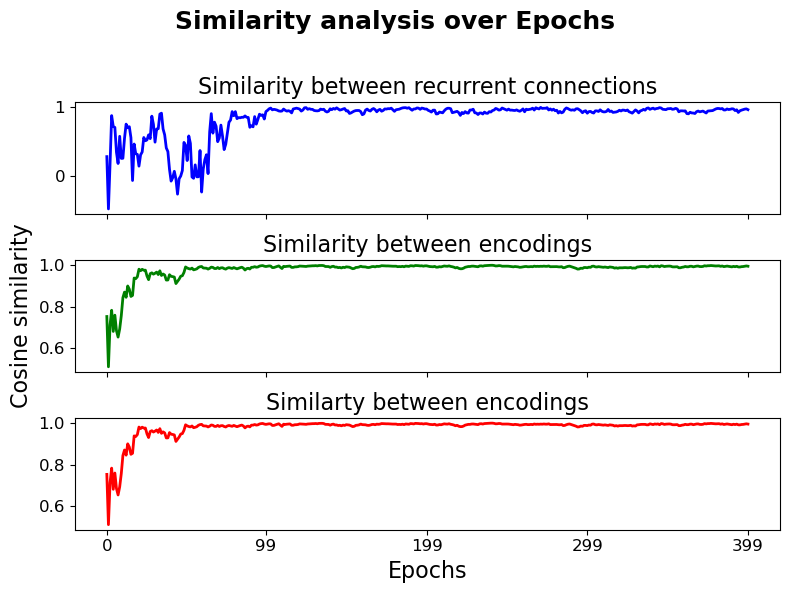

In [89]:
epochs_array = np.arange(epochs)
# Create a single figure with three subplots, adjusting figure size
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))  # Increased size
fig.suptitle("Similarity analysis over Epochs", fontsize=18, fontweight='bold')

# Define larger font sizes for better readability
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

# First plot
axes[0].plot(epochs_array, symmetry_V1_V2, color='blue', linewidth=2)
axes[0].set_title("Similarity between recurrent connections", fontsize=title_fontsize)
#axes[0].legend(fontsize=legend_fontsize)

# Second plot (Middle one - Only this gets the y-axis label)
axes[1].plot(epochs_array, symmetry_V1_H_V2_H, color='green', linewidth=2)
axes[1].set_ylabel("Cosine similarity", fontsize=label_fontsize)
axes[1].set_title("Similarity between encodings", fontsize=title_fontsize)
#axes[1].legend(fontsize=legend_fontsize)

# Third plot
axes[2].plot(epochs_array, symmetry_H_V1_H_V2, color='red', linewidth=2)
axes[2].set_xlabel("Epochs", fontsize=label_fontsize)
axes[2].set_title("Similarty between encodings", fontsize=title_fontsize)
#axes[2].legend(fontsize=legend_fontsize)

# Adjust x-axis ticks for readability
axes[2].set_xticks(np.linspace(0, epochs - 1, num=5, dtype=int))  # Fewer ticks

# Remove grid and increase tick font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(False)

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("similarity_analysis.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Test the model for reconstruction (denoising) of the training set
temperature = 10
n_steps = 10
for i in range(dataset.size(0)):
    original_data = dataset[i]
    clamped_units = torch.zeros(model.n)
    reconstructed_data, _ = model.GoToEquilibriumState(original_data, clamped_units, temperature,n_steps)
    
    # Visualize original vs reconstructed data
    VisualizeReconstruction(original_data.numpy(), reconstructed_data.numpy())